In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#df = pd.read_csv("export_dataframe.csv", encoding = 'utf-8')
df = pd.read_csv("smallsample.csv", encoding = 'utf-8')

In [2]:
import itertools # we will use this library tools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): # choosing blue theme for the graph
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # calculating the outlining indicators 
        
    print(cm) # printing the confusion matrix
    # designing the graph:
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # will be displaying data as 2D image
    plt.title(title) # adding title
    plt.colorbar() # adding colorbar
    # setting tick marks:
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # editing the indicators representation on the graph:
    fmt = '.2f' if normalize else 'd' # setting the data type
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),                              # formatting the text
                 horizontalalignment="center",                             # setting central allignment
                 color="white" if cm[i, j] > thresh else "black")          # setting color of the text

    plt.tight_layout() # adjusting plot parameters for a better fit in to the figure area
    # setting the axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#df = df.sample(frac=0.2, random_state=122)
df = df.sample(frac=1, random_state=122)
# random state 217 works

### Random Forest 

In [4]:
# features = ['Gender','Reality','wkphone']  with this it works 
features = ['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_medium',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_Laborwk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow'] 

nb_train = int(np.floor(0.9 * len(df)))
df = df.sample(frac=1, random_state=217)
X_train = df[features][:nb_train]
y_train = df['target'][:nb_train].values
X_test = df[features][nb_train:]
y_test = df['target'][nb_train:].values

In [5]:
def entropy(p):
    if p == 0:
        return 0
    elif p == 1:
        return 0
    else:
        return - (p * np.log2(p) + (1 - p) * np.log2(1-p))

def information_gain(left_child, right_child):
    parent = left_child + right_child
    p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
    p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
    p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
    IG_p = entropy(p_parent)
    IG_l = entropy(p_left)
    IG_r = entropy(p_right)
    return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r

In [6]:
def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train.iloc[bootstrap_indices].values
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train.iloc[oob_indices].values
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_tree(tree, X_test[i])
        if pred != y_test[i]:
            mis_label += 1
    return mis_label / len(X_test)

In [7]:
def find_split_point(X_bootstrap, y_bootstrap, max_features):
    feature_ls = list()
    num_features = len(X_bootstrap[0])
    while len(feature_ls) <= max_features:
        feature_idx = random.sample(range(num_features), 1)
        if feature_idx not in feature_ls:
            feature_ls.extend(feature_idx)

    best_info_gain = -999
    node = None
    for feature_idx in feature_ls:
        for split_point in X_bootstrap[:,feature_idx]:
            left_child = {'X_bootstrap': [], 'y_bootstrap': []}
            right_child = {'X_bootstrap': [], 'y_bootstrap': []}

        # split children for continuous variables
        if type(split_point) in [int, float]:
            for i, value in enumerate(X_bootstrap[:,feature_idx]):
                if value <= split_point:
                    left_child['X_bootstrap'].append(X_bootstrap[i])
                    left_child['y_bootstrap'].append(y_bootstrap[i])
                else:
                    right_child['X_bootstrap'].append(X_bootstrap[i])
                    right_child['y_bootstrap'].append(y_bootstrap[i])
        # split children for categoric variables
        else:
            for i, value in enumerate(X_bootstrap[:,feature_idx]):
                if value == split_point:
                    left_child['X_bootstrap'].append(X_bootstrap[i])
                    left_child['y_bootstrap'].append(y_bootstrap[i])
                else:
                    right_child['X_bootstrap'].append(X_bootstrap[i])
                    right_child['y_bootstrap'].append(y_bootstrap[i])

        split_info_gain = information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
        if split_info_gain > best_info_gain:
            best_info_gain = split_info_gain
            left_child['X_bootstrap'] = np.array(left_child['X_bootstrap'])
            right_child['X_bootstrap'] = np.array(right_child['X_bootstrap'])
            node = {'information_gain': split_info_gain,
                    'left_child': left_child,
                    'right_child': right_child,
                    'split_point': split_point,
                    'feature_idx': feature_idx}


    return node

In [8]:
def terminal_node(node):
    y_bootstrap = node['y_bootstrap']
    pred = max(y_bootstrap, key = y_bootstrap.count)
    return pred


def split_node(node, max_features, min_samples_split, max_depth, depth):
    left_child = node['left_child']
    right_child = node['right_child']

    del(node['left_child'])
    del(node['right_child'])

    if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
        empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
        node['left_split'] = terminal_node(empty_child)
        node['right_split'] = terminal_node(empty_child)
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child)
        node['right_split'] = terminal_node(right_child)
        return node

    if len(left_child['X_bootstrap']) <= min_samples_split:
        node['left_split'] = node['right_split'] = terminal_node(left_child)
    else:
        node['left_split'] = find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
        split_node(node['left_split'], max_depth, min_samples_split, max_depth, depth + 1)
    if len(right_child['X_bootstrap']) <= min_samples_split:
        node['right_split'] = node['left_split'] = terminal_node(right_child)
    else:
        node['right_split'] = find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
        split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)

In [9]:
def build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
    root_node = find_split_point(X_bootstrap, y_bootstrap, max_features)
    split_node(root_node, max_features, min_samples_split, max_depth, 1)
    return root_node

def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    tree_ls = list()
    oob_ls = list()
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        tree = build_tree(X_bootstrap, y_bootstrap, max_features, max_depth, min_samples_split)
        tree_ls.append(tree)
        oob_error = oob_score(tree, X_oob, y_oob)
        oob_ls.append(oob_error)
    print("OOB estimate: {:.2f}".format(np.mean(oob_ls)))
    return tree_ls

In [10]:
def predict_tree(tree, X_test):
    feature_idx = tree['feature_idx']

    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']

In [11]:
def predict_rf(tree_ls, X_test):
    pred_ls = list()
    for i in range(len(X_test)):
        ensemble_preds = [predict_tree(tree, X_test.values[i]) for tree in tree_ls]
        final_pred = max(ensemble_preds, key = ensemble_preds.count)
        pred_ls.append(final_pred)
    return np.array(pred_ls)

In [12]:
n_estimators = 50
max_features = 3
max_depth = 10
min_samples_split = 2

model = random_forest(X_train, y_train, n_estimators=50, max_features=3, max_depth=10, min_samples_split=2)

OOB estimate: 0.49


In [13]:
preds = predict_rf(model, X_test)
acc = sum(preds == y_test) / len(y_test)
print("Testing accuracy: {}".format(np.round(acc,3)))

Testing accuracy: 0.59


Accuracy Score is 0.59
    0   1
0  22  30
1  11  37
[[0.42307692 0.57692308]
 [0.22916667 0.77083333]]


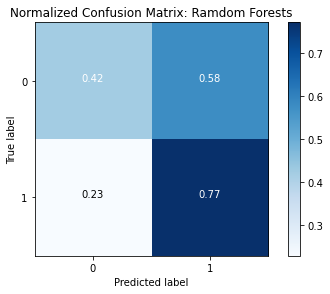

In [14]:
print('Accuracy Score is',accuracy_score(y_test, preds))
print(pd.DataFrame(confusion_matrix(y_test,preds)))

plot_confusion_matrix(confusion_matrix(y_test,preds),
                      classes= ['0','1'], normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')